In [2]:
import scipy.sparse as sp
import argparse
import numpy as np
import os
import time
import polars as pl
import linear_dag as ld
from linear_dag.core.lineararg import LinearARG
import pandas as pd

In [21]:
def get_sum_matrix(N, M):
    data = np.ones(2*N)
    row_indices = np.repeat(np.arange(N), 2)
    col_indices = np.arange(2*N)
    S = sp.csr_matrix((data, (row_indices, col_indices)), shape=(N, 2*N))
    return S


def linarg_regression(linarg, y, R, C):
    
    N_total = int(linarg.shape[0] / 2)
    M = int(linarg.shape[1])
    S = get_sum_matrix(N_total, M)
    N = R.shape[0]

    start = time.time()
    X = sp.linalg.aslinearoperator(R) @ sp.linalg.aslinearoperator(S) @ linarg.normalized
    P = sp.linalg.aslinearoperator(sp.eye(N)) - sp.linalg.aslinearoperator(C) @ sp.linalg.aslinearoperator(sp.linalg.spsolve(C.T @ C, C.T))
    y_resid = P @ y.T
    y_resid = y_resid - np.mean(y_resid)
    y_resid = y_resid / np.std(y_resid)
    beta_hat = (X.T @ P.T @ P @ y_resid) / (2**0.5 * N)
    end = time.time()
        
    return beta_hat, end-start


def genotypes_regression(genotypes, y, R, C):
    
    N_total = int(genotypes.shape[0] / 2)
    M = int(genotypes.shape[1])
    S = get_sum_matrix(N_total, M)
    N = R.shape[0]
    
    start = time.time()
    allele_frequencies = np.ones(genotypes.shape[0]) @ genotypes / genotypes.shape[0]
    mean = sp.linalg.aslinearoperator(np.ones((genotypes.shape[0], 1))) @ sp.linalg.aslinearoperator(allele_frequencies)
    pq = allele_frequencies * (1 - allele_frequencies)
    pq[pq == 0] = 1
    G = (sp.linalg.aslinearoperator(genotypes) - mean) * sp.linalg.aslinearoperator(sp.diags(pq**-0.5))
    X = sp.linalg.aslinearoperator(R) @ sp.linalg.aslinearoperator(S) @ G    
    P = sp.linalg.aslinearoperator(sp.eye(N)) - sp.linalg.aslinearoperator(C) @ sp.linalg.aslinearoperator(sp.linalg.spsolve(C.T @ C, C.T))
    y_resid = P @ y.T
    y_resid = y_resid - np.mean(y_resid)
    y_resid = y_resid / np.std(y_resid)
    beta_hat = (X.T @ P.T @ P @ y_resid) / (2**0.5 * N)
    end = time.time()
    
    return beta_hat, end-start

In [11]:
N_total = int(genotypes.shape[0] / 2)
M = int(genotypes.shape[1])
S = get_sum_matrix(N_total, M)
N = R.shape[0]

allele_frequencies = np.ones(genotypes.shape[0]) @ genotypes / genotypes.shape[0]
mean = sp.linalg.aslinearoperator(np.ones((genotypes.shape[0], 1))) @ sp.linalg.aslinearoperator(allele_frequencies)
pq = allele_frequencies * (1 - allele_frequencies)
pq[pq == 0] = 1
G = (sp.linalg.aslinearoperator(genotypes) - mean) * sp.linalg.aslinearoperator(sp.diags(pq**-0.5))
X = sp.linalg.aslinearoperator(R) @ sp.linalg.aslinearoperator(S) @ G    
CCTCinvCT = sp.linalg.aslinearoperator(C) @ sp.linalg.aslinearoperator(sp.linalg.spsolve(C.T @ C, C.T))
P = sp.linalg.aslinearoperator(sp.eye(N)) - CCTCinvCT
# beta_hat = (X.T @ P.T @ P).dot(y.T) / (2**0.5 * N)

beta_hat = (X.T @ P.T @ P).dot(y.T) / ((P @ X).T @ (P @ X))

TypeError: unsupported operand type(s) for /: 'numpy.ndarray' and '_ProductLinearOperator'

In [5]:
from scipy.io import mmread

mtx_path = "../../../data/1kg_ALL_chr22_47876022_49355984_MAF_0.01_RF_0.01_T_8.genos.mtx"
genotypes = mmread(mtx_path).tocsc()
linarg = ld.LinearARG.from_genotypes(genotypes)
linarg = linarg.make_triangular()

In [10]:
np.random.seed(42)

N = int(genotypes.shape[0] / 2)
M = genotypes.shape[1]
S = get_sum_matrix(N, M)
R = sp.eye(N)
y = np.random.normal(0, 1, N)
C = sp.csr_matrix(np.random.normal(0, 1, (N, 20)))

In [20]:
beta_hat_linarg, linarg_time = linarg_regression(linarg, y, R, C)

In [22]:
beta_hat_genotypes, genotypes_time = genotypes_regression(genotypes, y, R, C)

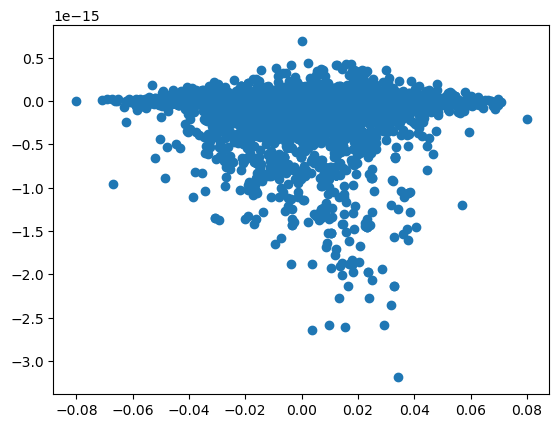

In [37]:
import matplotlib.pyplot as plt

plt.scatter(beta_hat_genotypes, beta_hat_linarg.T.flatten()-beta_hat_genotypes)
plt.show()

In [38]:
linarg_time, genotypes_time

(0.4588470458984375, 0.27379822731018066)

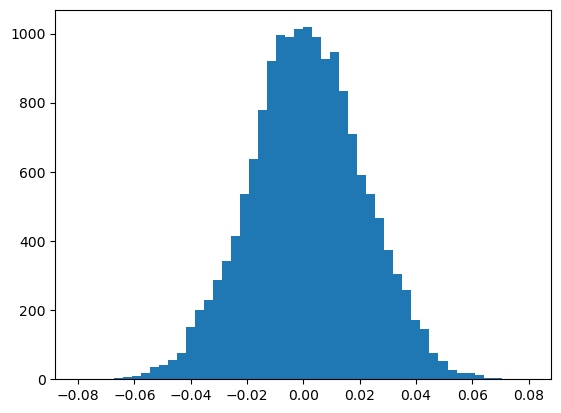

In [39]:
plt.hist(beta_hat_genotypes, bins=50)
plt.show()

In [52]:
beta_hat_genotypes

array([[ 0.01539995],
       [ 0.01807587],
       [-0.02538654],
       ...,
       [ 0.00404957],
       [ 0.03650463],
       [-0.00631594]])

In [11]:
np.random.seed(0)

print(np.random.uniform(0, 10, 10))

print(np.random.uniform(0, 100, 10))

[5.48813504 7.15189366 6.02763376 5.44883183 4.23654799 6.45894113
 4.37587211 8.91773001 9.63662761 3.83441519]
[79.17250381 52.88949198 56.80445611 92.55966383  7.10360582  8.71292997
  2.02183974 83.26198455 77.81567509 87.00121482]


In [ ]:
sp.aslinearoperator